In [ ]:
#File description & paths to csv's
"""
Code is divided into the following sections:
1. Import of data & dataframe def
2. Enrich credit data and define labels 
3. Merge app & labelled credit data
4. Application functions to take user input
5. Application engine making interactive filtering

The followind dataframes are available as result:
*** credit_records_o ***contains credit_records from csv file, same structure as in the file
*** application_records_o *** contains data from application csv, file same structure as in the file

*** credit_records_p is ***same as credit_records_0 but in alternative structure (rows = ID, columns= MONTH_BALANCE, values=STATUs for a given ID and month)
*** credit_records_p_labelled=p.copy() *** credit_records_p enriched with start, end, duration, counts of all statuses and ratio of them

*** app_and_credit_label_2 *** merge between app & labelled credit data. Define categorical columns on employement, birth, income.

*** final_layout - launches the interative form to take users input and filter charts


path_to_credit_records_csv='C:\\Users\\User\\OneDrive\\Desktop\\Kurs\\Projekt\\Python\\Dane\\credit_record.csv' #replace with your path to credit records.csv
path_to_application_records_csv='C:\\Users\\User\\OneDrive\\Desktop\\Kurs\\Projekt\\Python\\Dane\\application_record.csv' #replace with your path to credit records.csv

In [ ]:
### 1. Import of data & dataframe def 
import csv
import pandas as pd

#create credit_records_o from data in csv
file=open(path_to_credit_records_csv) 
credit_records_o=pd.read_csv(file) 
file.close()

#create application_records_o from data in csv
file=open(path_to_application_records_csv) 
application_records_o=pd.read_csv(file) 
file.close()

#create wide version of credit_records
credit_records_p=pd.pivot(credit_records_o, index='ID',columns='MONTHS_BALANCE',values='STATUS') 
credit_records_p = credit_records_p[credit_records_p.columns.sort_values(ascending=False)] #reorder months balance column in descending order

In [ ]:
### 2. Enrich credit data and define labels 

from collections import Counter
p=credit_records_p.copy() 

#add colulmns with val_count(count of statuses), start (first month of loan), end (last month of loan), duration (loan duration)
p['val_count']=p.apply(lambda x: Counter(x),axis=1) 
grouped_id=credit_records_o.groupby('ID')
p['start_mth']=grouped_id['MONTHS_BALANCE'].min()
p['end_mth']=grouped_id['MONTHS_BALANCE'].max()
p['duration']=abs(p['start_mth']-p['end_mth'])+1 

#add columns with 0,1,2,3,4,5 statuses count and their ratios per client
p['0_count']=p['val_count'].apply(lambda x: x.get('0',0)) 
p['0_ratio']=p['0_count']/p['duration'] 
p['1_count']=p['val_count'].apply(lambda x: x.get('1',0)) 
p['1_ratio']=p['1_count']/p['duration'] 
p['2_count']=p['val_count'].apply(lambda x: x.get('2',0))
p['2_ratio']=p['2_count']/p['duration'] 
p['3_count']=p['val_count'].apply(lambda x: x.get('3',0))
p['3_ratio']=p['3_count']/p['duration'] 
p['4_count']=p['val_count'].apply(lambda x: x.get('4',0))
p['4_ratio']=p['4_count']/p['duration'] 
p['5_count']=p['val_count'].apply(lambda x: x.get('5',0))
p['5_ratio']=p['5_count']/p['duration'] 
p['cr_late_count']=p['val_count'].apply(lambda x: x.get('0',0)+x.get('1',0)+x.get('2',0)+x.get('3',0)+x.get('4',0)+x.get('5',0)) 
p['cr_late_ratio']=p['cr_late_count']/p['duration'] 

credit_records_p_labelled=p.copy()

In [ ]:
### 3. Merge app & labelled credit data
app_and_credit_label_2=application_records_o.merge(credit_records_p_labelled,on='ID')

app_and_credit_label_2['income_bin']=pd.cut(app_and_credit_label_2['AMT_INCOME_TOTAL'],bins=20)
app_and_credit_label_2['age']=round((app_and_credit_label_2['DAYS_BIRTH']/365),0)
app_and_credit_label_2['length_of_empl']=round((app_and_credit_label_2['DAYS_EMPLOYED']/365),0)

In [ ]:
### 4. Application functions

features=['ID', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','CNT_FAM_MEMBERS']

def_code_gender=app_and_credit_label_2['CODE_GENDER'].unique()
features_excluded=['val_count', 'start_mth', 'end_mth', 'duration', 'cr_late_count', 'cr_late_ratio', 'cr_late_bin', 'cr_income_bin', 'default','default_f']

def set_filter(dic: dict):
    """ This function constructs a dictionary representation of user selection.
    i.e if user selected: 'CODE_GENDER': 'M','FLAG_OWN_CAR': 'Y','CNT_CHILDREN': 1, the output will be:
    {'ID': None, 'CODE_GENDER': 'M', 'FLAG_OWN_CAR': 'Y', 'FLAG_OWN_REALTY': None, 'CNT_CHILDREN': 1, 'AMT_INCOME_TOTAL': None, 'NAME_INCOME_TYPE': None, 'NAME_EDUCATION_TYPE': None, 'NAME_FAMILY_STATUS': None, 'NAME_HOUSING_TYPE': None, 'DAYS_BIRTH': None, 'DAYS_EMPLOYED': None, 'FLAG_MOBIL': None, 'FLAG_WORK_PHONE': None, 'FLAG_PHONE': None, 'FLAG_EMAIL': None, 'OCCUPATION_TYPE': None, 'CNT_FAM_MEMBERS': None}
    """
    #construct curr_filter dictionary with None values for all features
    features=['ID', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','CNT_FAM_MEMBERS']
    values=[None]*len(features)
    curr_filter=dict(zip(features,values))
    #read what was provided in dic and set those keys only to sth
    for key, val in dic.items():
        #print(key,val)
        curr_filter[key]=val
    return curr_filter

def gen_condition_str(filter: dict):
    """ This function takes a list of keys & values and makes a qeury out of them.
    I.e. {'ID': None, 'CODE_GENDER': 'M', 'FLAG_OWN_CAR': 'Y', 'FLAG_OWN_REALTY': None, 'CNT_CHILDREN': 1, 'AMT_INCOME_TOTAL': None, 'NAME_INCOME_TYPE': None, 'NAME_EDUCATION_TYPE': None, 'NAME_FAMILY_STATUS': None, 'NAME_HOUSING_TYPE': None, 'DAYS_BIRTH': None, 'DAYS_EMPLOYED': None, 'FLAG_MOBIL': None, 'FLAG_WORK_PHONE': None, 'FLAG_PHONE': None, 'FLAG_EMAIL': None, 'OCCUPATION_TYPE': None, 'CNT_FAM_MEMBERS': None}
    will return: CODE_GENDER == 'M' & FLAG_OWN_CAR == 'Y' & CNT_CHILDREN == 1 which can be used in df.query
    """
    query=" & ".join(f"{key} == {repr(val)}" for key,val in filter.items() if val!=None and key!='income_bin') #dynamic column & values filtering where columns can take string values - must use the repr function https://www.semicolonworld.com/question/59812/dynamically-filtering-a-pandas-dataframe
    if filter['income_bin']==None:
        return query
    else:
        if len(query)==0:
            query="income_bin.astype('str') == '{}'".format(filter['income_bin'])
            return query
        else:
            query=query + " & income_bin.astype('str') == '{}'".format(filter['income_bin'])
            return query

In [ ]:
### 5. Application engine
import ipywidgets as widgets
import matplotlib.pyplot as plt


#Define widgets to get user input
sex = widgets.Dropdown(options=['M','F',None],value=None, description='Sex')
car = widgets.Dropdown(options=['N','Y',None], value=None, description='Own Car')
realty = widgets.Dropdown(options=['N','Y',None], value=None, description='Own Realty')
children = widgets.Dropdown(options=[*range(11),None],value=None,description="Childrens Number")
t=app_and_credit_label_2['income_bin'].sort_values().unique()
income_amt=widgets.Dropdown(options=[*t,None],value=None, description='Yearly Income')
income_type =widgets.Dropdown(options=['State servant', 'Student', 'Commercial associate', 'Pensioner', 'Working',None],value=None, description='Income_type')# b = widgets.IntSlider(description='b')
education_type = widgets.Dropdown(options=['Incomplete higher', 'Academic degree', 'Higher education', 'Secondary / secondary special', 'Lower secondary',None],value=None, description='Education')
family_status = widgets.Dropdown(options=['Widow', 'Married', 'Single / not married', 'Civil marriage', 'Separated',None],value=None,description='Family Status')
housting_type= widgets.Dropdown(options=['Municipal apartment', 'Office apartment','House / apartment','With parents','Co-op apartment','Rented apartment',None],value=None, description="Housing Type")
birth_date = widgets.Dropdown(options=[*range(18,100,1),None], value=None, description="Birth Date")
employment_date = widgets.Dropdown(options=[*range(0,50,1),None], value=None, description="Employment Date")
occupation_type = widgets.Dropdown(options=['High skill tech staff','Private service staff','Managers','Sales staff','Secretaries','IT staff','Realty agents','HR staff','Low-skill Laborers','Accountants',
 'Waiters/barmen staff', 'Core staff', 'Cleaning staff', 'Medicine staff', 'Drivers', 'Laborers','Cooking staff','Security staff',None],value=None,description="Occupation")
submit_button=widgets.Button(description='Submit')

#Below is just a list of dataframe columns and ones that were added to widgets and those that weren't
Columns_Full=['ID', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'age', 'length_of_empl', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','CNT_FAM_MEMBERS']
Columns_Ommitted=['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL','CNT_FAM_MEMBERS','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED']

#capture all values of widgets
def read_values():
    """Captures values of all widgets and returns them as dictionary e.g. {'CODE_GENDER':'M, 'FLAG_OWN_CAR':'Y'...}"""
    dic_keys=['CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'age', 'length_of_empl', 'OCCUPATION_TYPE']
    dic_values=[sex.value, car.value ,realty.value ,children.value,income_amt.value,income_type.value,education_type.value,family_status.value,housting_type.value,
    -1*birth_date.value if birth_date.value!=None else None, -1*employment_date.value if employment_date.value!=None else None, occupation_type.value]
    return dict(zip(dic_keys,dic_values))

#Print values of widgest on change of any of them
def print_values(a,b,c,d,e,f,g,h,i,j,k,l):
    """Print current values of widgets"""
    print(print(read_values()))
values_of_widgets = widgets.interactive_output(print_values,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

#Print condition generated on back of dictionary of widgets values
def print_condition(a,b,c,d,e,f,g,h,i,j,k,l):
    """Print condition based on values of widgets"""
    print(print(gen_condition_str(read_values())))
condition_generated = widgets.interactive_output(print_condition,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

###########################################HISTOGRAM PLOTS
#Plots a unfiltered chart on all values
def plot_unfiltered():
    data=app_and_credit_label_2['cr_late_ratio']
    mean_v=app_and_credit_label_2['cr_late_ratio'].mean()
    plt.hist(app_and_credit_label_2['cr_late_ratio'],density=True,label="Late ratio. Records {}. Mean late {:.2f}".format(len(data),mean_v))
    plt.legend()
    plt.show()
chart_unfiltered = widgets.interactive_output(plot_unfiltered, {})

#Plots a chart filtered down to user selection via widgets and also prints in legend number of records meeting selection criteria
def plot_filtered(a,b,c,d,e,f,g,h,i,j,k,l):
    """Plots cr_late_ratio with data filtered to the one selected on widgets"""
    if len(gen_condition_str(read_values()))!=0: #check if there is any condition if not it will plot all records
        data=app_and_credit_label_2.query(gen_condition_str(read_values()),engine='python')['cr_late_ratio']
        if len(data)!=0: #checks if there is any data in the intersection of user seleciton if not will print msg saying theres none
            mean_v=data.mean()
            plt.hist(data,density=True,label="Late ratio. Records: {}, Mean {:.2f}".format(len(data),mean_v))
            plt.legend()
            plt.show()
        else:
            print('There are no records in this selection')
    else:
        plt.hist(app_and_credit_label_2['cr_late_ratio'],density=True,label="Late ratio on filtered records ({})".format(len(app_and_credit_label_2)),bins=10)
        plt.legend()
        plt.show()

chart_filtered = widgets.interactive_output(plot_filtered,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

###########################################Box Plots
#Plots a unfiltered chart on all values
def plot_unfiltered_box():
    plt.boxplot(app_and_credit_label_2['cr_late_ratio'])
    plt.show()
chart_unfiltered_box = widgets.interactive_output(plot_unfiltered_box, {})

#Plots a chart filtered down to user selection via widgets and also prints in legend number of records meeting selection criteria
def plot_filtered_box(a,b,c,d,e,f,g,h,i,j,k,l):
    """Plots cr_late_ratio with data filtered to the one selected on widgets"""
    if len(gen_condition_str(read_values()))!=0:
        data=app_and_credit_label_2.query(gen_condition_str(read_values()))['cr_late_ratio']
        plt.boxplot(data)
        plt.show()
    else:
        plt.boxplot(app_and_credit_label_2['cr_late_ratio'])
        plt.show()

chart_filtered_box = widgets.interactive_output(plot_filtered_box,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

#Construct layout of on vertical box contatining a number of horizontal boxes that contain widgets
input_widgets=widgets.VBox([
    widgets.HBox([sex, realty, car]),
    widgets.HBox([children,income_type,education_type]),
    widgets.HBox([family_status, housting_type,occupation_type]),
    widgets.HBox([birth_date,employment_date,income_amt]),
    # widgets.HBox([values_of_widgets]),
    # widgets.HBox([condition_generated])
    ])

chart_widgets_hist=widgets.HBox([chart_unfiltered,chart_filtered])
chart_widgets_box=widgets.HBox([chart_unfiltered_box,chart_filtered_box])

final_layout=widgets.VBox([input_widgets,chart_widgets_hist,chart_widgets_box])

final_layout


<AxesSubplot:title={'center':'Overall lateness ratio by: DAYS_BIRTH'}>

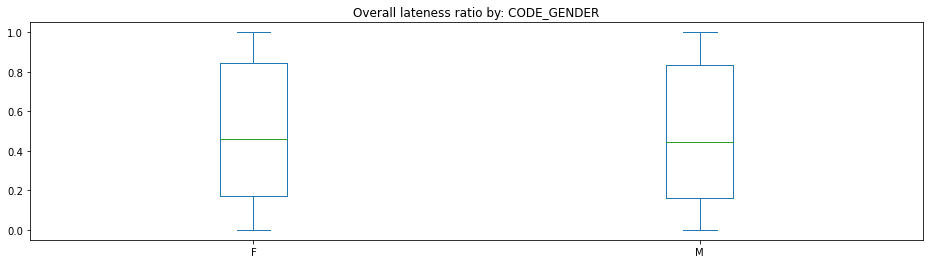

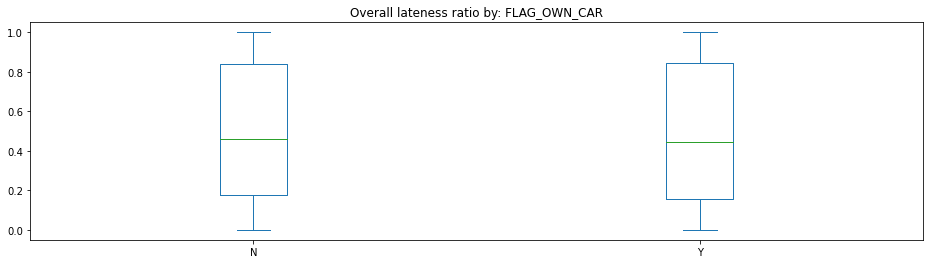

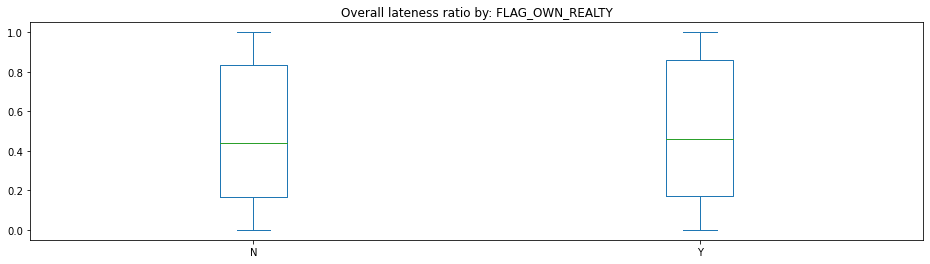

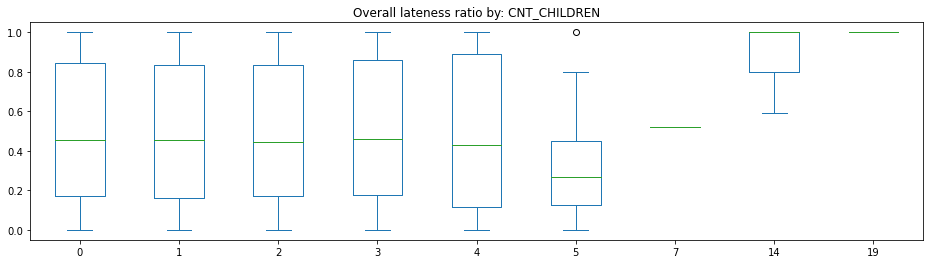

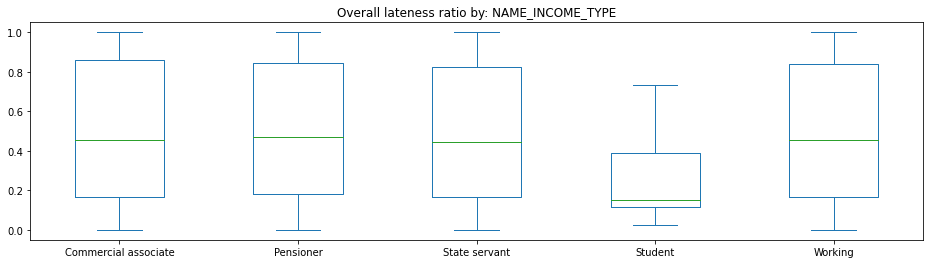

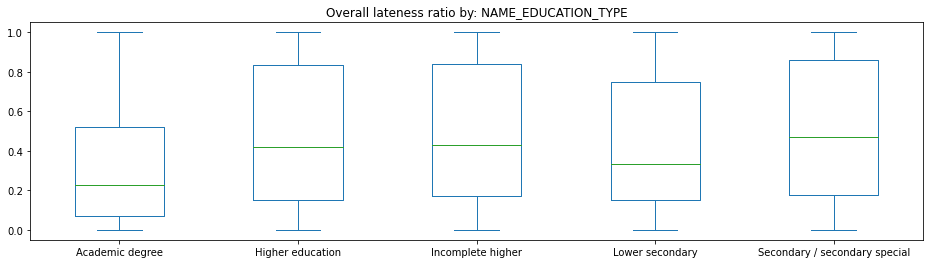

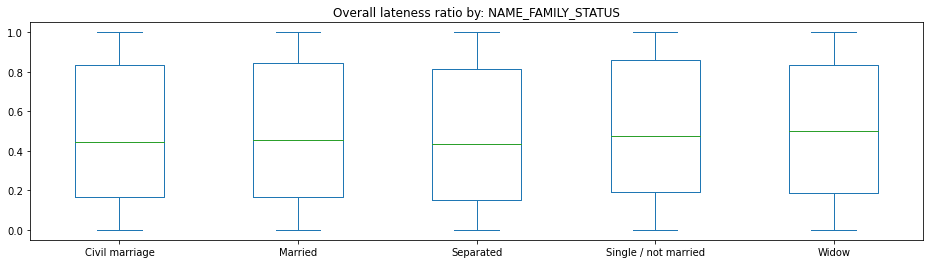

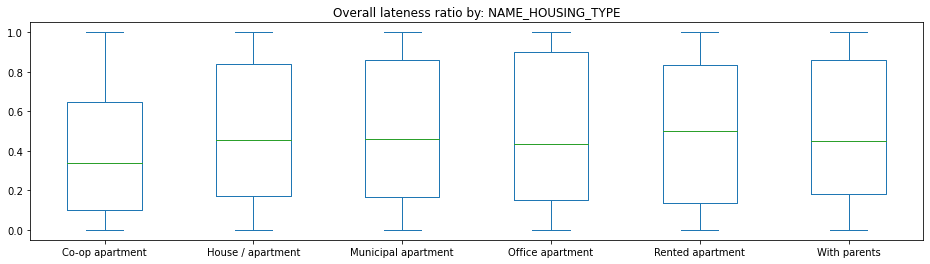

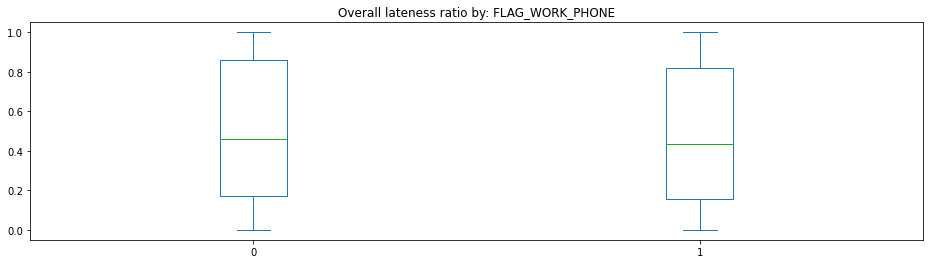

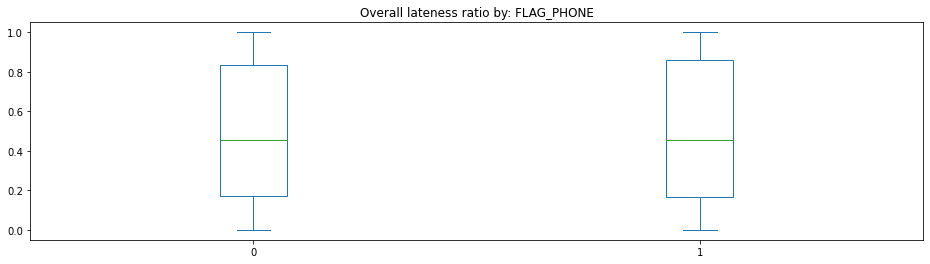

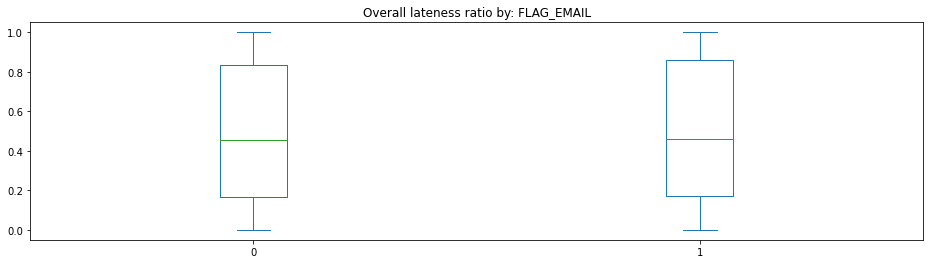

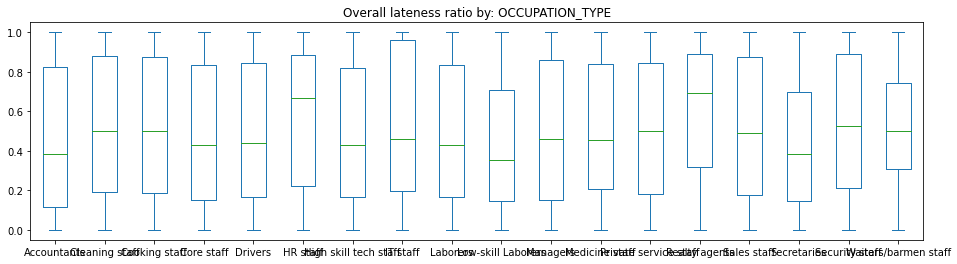

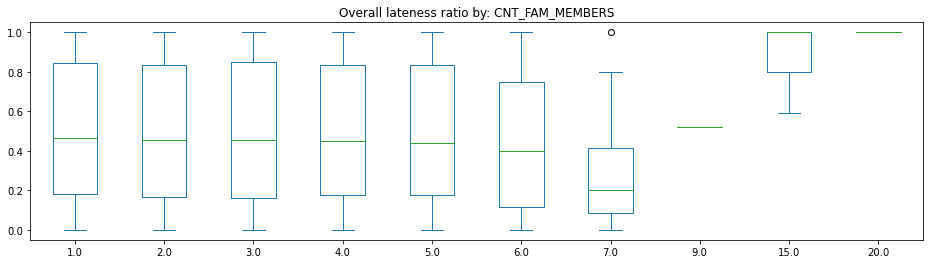

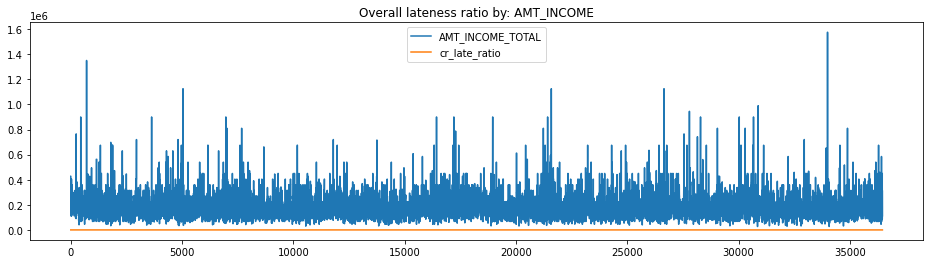

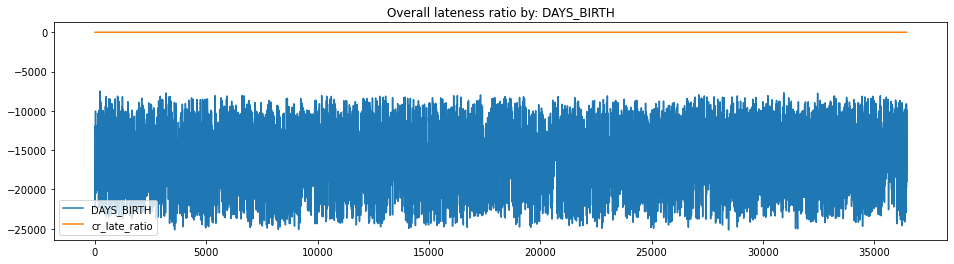

In [28]:
# Compare features vs label with charts
features=['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL', 'OCCUPATION_TYPE','CNT_FAM_MEMBERS']
features_excl=['AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED']

for el in features:
    app_and_credit_label_2[[el,'cr_late_ratio','ID']].pivot_table(index='ID',columns=el, values='cr_late_ratio').plot(kind='box',figsize=[16,4],title='Overall lateness ratio by: ' + el)

app_and_credit_label_2[['AMT_INCOME_TOTAL','cr_late_ratio']].plot(figsize=[16,4],title='Overall lateness ratio by: ' + 'AMT_INCOME')
app_and_credit_label_2[['DAYS_BIRTH','cr_late_ratio']].plot(figsize=[16,4],title='Overall lateness ratio by: ' +'DAYS_BIRTH')




In [31]:
app_and_credit_label_2['cr_late_ratio'].value_counts(ascending=False)

1.000000    5050
0.000000    4455
0.500000    1284
0.666667     794
0.750000     743
            ... 
0.803279       1
0.573770       1
0.950820       1
0.490909       1
0.808511       1
Name: cr_late_ratio, Length: 984, dtype: int64